# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt
import pandas as pd
import shap

# Reading data and pre-processing

In [3]:
# loading csv
df = pd.read_csv('data/fpl_fbref_elo_lstm.csv')

In [4]:
# removing unnamed columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [5]:
df.columns

Index(['Date', 'Day', 'Comp', 'Round', 'Venue', 'Squad', 'Opponent', 'Start',
       'Pos', 'Min', 'Gls', 'Ast', 'PK', 'PKatt', 'Sh', 'SoT', 'CrdY', 'CrdR',
       'Touches', 'Tkl', 'Int', 'Blocks', 'xG', 'npxG', 'xAG', 'SCA', 'GCA',
       'Cmp', 'Att', 'Cmp%', 'Prog', 'Succ', 'Att.1', 'Match Report', 'Name',
       'Season', 'WDL', 'GoalsTeams', 'Team Score', 'Opp Score', 'CS',
       'Was Home', 'GW', 'FPL', 'neutral_name', 'Total Points', 'Opp rating',
       'LSTM'],
      dtype='object')

In [46]:
df.iloc[0]

Date                       2022-08-06
Day                               Sat
Comp                   Premier League
Round                     Matchweek 1
Venue                            Home
Squad                    Leeds United
Opponent                       Wolves
Start                               Y
Pos                                RW
Min                              83.0
Gls                               0.0
Ast                               0.0
PK                                0.0
PKatt                             0.0
Sh                                1.0
SoT                               0.0
CrdY                              0.0
CrdR                              0.0
Touches                          35.0
Tkl                               2.0
Int                               0.0
Blocks                            2.0
xG                                0.0
npxG                              0.0
xAG                               0.0
SCA                               1.0
GCA         

In [6]:
# dropping NaNs
# df = df.dropna(axis=0)

In [7]:
# df[df["Name"] == "Mohamed-Salah"]

# Choosing features and splitting data

In [13]:
features = ["LSTM", "Was Home", "Opp rating", 'ScoreForLast5', 'ScoreAgainstLast5']
info = ["Name", "GW", "Squad", "Opponent", "Was Home", "Opp rating"]
to_predict = ["FPL"]

In [14]:
GAMEWEEK_TO_PREDICT = 18

In [15]:
# gameweeks 9-14 is training data, gw 15 is test data
X_train = df[(df["GW"] >= 9) & (df["GW"] <= GAMEWEEK_TO_PREDICT - 1)][features]
y_train = df[(df["GW"] >= 9) & (df["GW"] <= GAMEWEEK_TO_PREDICT - 1)][to_predict]

In [16]:
X_test = df[df["GW"] == GAMEWEEK_TO_PREDICT][features]
y_test = df[df["GW"] == GAMEWEEK_TO_PREDICT][to_predict]

# Model

In [17]:
model = xgb.XGBRegressor()

In [18]:
%%time
model.fit(X_train, y_train)

CPU times: total: 1.09 s
Wall time: 213 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [19]:
# make predictions on the test data
predictions = model.predict(X_test)

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# calculate the MAE and MSE scores
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

In [21]:
print("MAE: ", mae)
print("MSE: ", mse)

MAE:  1.078505639361326
MSE:  2.4083870425557667


# Predictions

In [27]:
X_test = df[df["GW"] == GAMEWEEK_TO_PREDICT][features]
y_test = df[df["GW"] == GAMEWEEK_TO_PREDICT][to_predict]

In [28]:
df_predictions = df[df["GW"] == GAMEWEEK_TO_PREDICT]

In [29]:
df_predictions.shape

(378, 50)

In [30]:
len(predictions)

378

In [31]:
df_predictions["pred"] = predictions


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [32]:
model.predict(df[df["GW"] == 18][df["Name"] == "Mohamed-Salah"][features])

Boolean Series key will be reindexed to match DataFrame index.


array([5.074069], dtype=float32)

In [33]:
df_predictions[info + to_predict + ["pred"]].sort_values(by=["pred"], ascending = False).head(20)

,Name,GW,Squad,Opponent,Was Home,Opp rating,FPL,pred
6712,Ivan-Toney,18,Brentford,West Ham,0.0,1763.013794,11.0,15.764972
3497,Harry-Kane,18,Tottenham,Aston Villa,1.0,1739.823853,2.0,8.614942
2307,Bruno-Fernandes,18,Manchester Utd,Wolves,0.0,1691.323364,6.0,8.560822
5492,Marcus-Rashford,18,Manchester Utd,Wolves,0.0,1691.323364,7.0,7.864028
2900,Erling-Haaland,18,Manchester City,Everton,1.0,1688.246216,7.0,7.395182
1914,Gabriel-Dos-Santos,18,Arsenal,Brighton,0.0,1799.850708,2.0,7.070316
4313,Martinelli,18,Arsenal,Brighton,0.0,1799.850708,7.0,7.048484
5042,Michael-Olise,18,Crystal Palace,Bournemouth,0.0,1656.823120,9.0,6.742164
7453,Martin-Odegaard,18,Arsenal,Brighton,0.0,1799.850708,10.0,5.759643
3086,Son-Heung-min,18,Tottenham,Aston Villa,1.0,1739.823853,2.0,5.747201


# Feature importance and influence

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

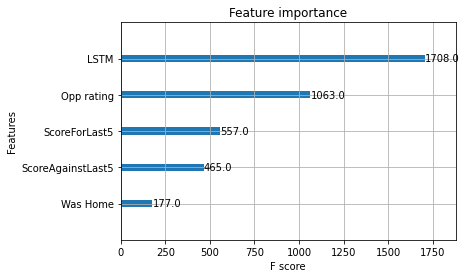

In [34]:
plot_importance(model)

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


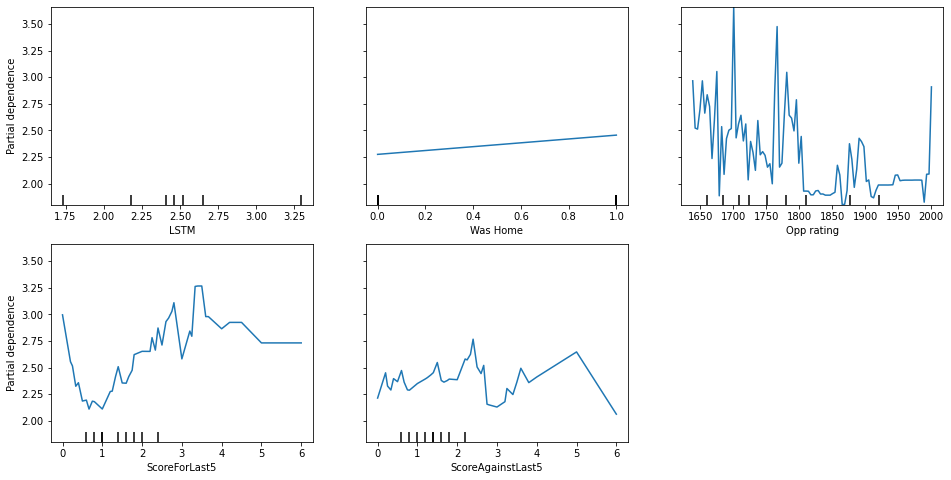

In [35]:
fig, ax = plt.subplots(figsize=(16, 8))
plot_partial_dependence(model, X_train, features, ax=ax)

In [36]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

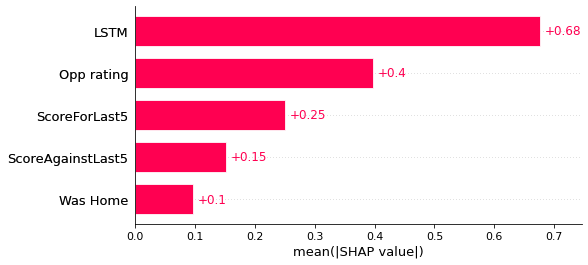

In [37]:
shap.plots.bar(shap_values)

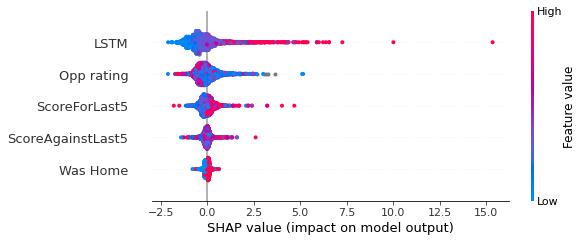

In [38]:
shap.plots.beeswarm(shap_values)

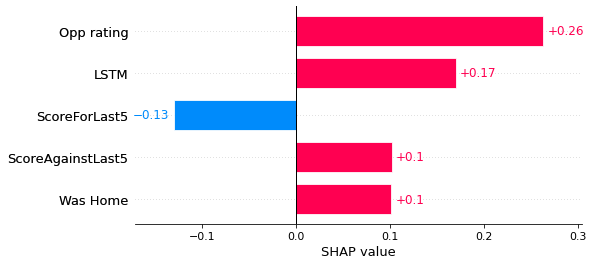

In [45]:
shap.plots.bar(shap_values[124])